In [1]:
library(tidyverse)
library(quanteda)
library(topicmodels)
library(glue)
library(topicdoc)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Package version: 3.0.0
Unicode version: 13.0
ICU version: 66.1

Parallel computing: 8 of 8 threads used.

See https://quanteda.io for tutorials and examples.


Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse




In [2]:
url = "https://cssbook.net/d/sotu.csv"
sotu = read_csv(url) 
p_obama = sotu %>% 
  filter(President == "Obama") %>% 
  corpus() %>% 
  corpus_reshape("paragraphs")
dfm = p_obama %>% 
  tokens(remove_punct=T) %>%
  dfm() %>% 
  dfm_remove(stopwords("english")) %>%
  dfm_trim(min_docfreq=.01,docfreq_type = "prop")
dfm


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  FirstName = col_character(),
  President = col_character(),
  Date = col_date(format = ""),
  delivery = col_character(),
  type = col_character(),
  party = col_character(),
  text = col_character()
)




Document-feature matrix of: 738 documents, 746 features (97.02% sparse) and 6 docvars.
         features
docs      speaker mr vice president members congress first united around come
  text1.1       1  1    1         1       1        1     1      1      1    0
  text1.2       0  0    0         0       0        0     0      0      0    1
  text1.3       0  0    0         0       0        0     0      0      0    0
  text1.4       0  0    0         0       0        0     0      1      0    0
  text1.5       0  0    0         0       0        0     0      0      0    0
  text1.6       0  0    0         0       0        0     0      0      0    0
[ reached max_ndoc ... 732 more documents, reached max_nfeat ... 736 more features ]

In [3]:
lda = dfm %>% 
  convert(to = "topicmodels") %>%
  LDA(k=10,control=list(seed=123, alpha = 1/1:10))



terms(lda, 10)

Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
college,care,us,can,years,energy,people,country,world,jobs
new,health,nation,make,first,change,get,time,american,year
workers,still,people,congress,economy,new,day,future,war,years
education,families,can,republicans,back,clean,now,american,security,new
help,americans,states,democrats,time,world,know,america,people,last
job,like,one,work,home,power,see,people,troops,tax
every,new,america,take,crisis,america,tax,done,us,million
kids,need,together,pay,financial,can,americans,work,america,$
small,must,united,cuts,two,economy,government,get,new,businesses
schools,job,president,banks,plan,research,american,now,nations,america


In [4]:
topics = posterior(lda)$topics %>% 
  as_tibble() %>% 
  rename_all(~paste0("Topic_", .))
meta = docvars(p_obama) %>% 
  select(President:Date) %>%
  add_column(doc_id=docnames(p_obama),.before=1)
tpd = bind_cols(meta, topics) 
head(tpd)

,doc_id,President,Date,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10
,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,text1.1,Obama,2009-02-24,0.013920249,0.013920249,0.681016299,0.013958435,0.109552840,0.013940244,0.013928915,0.013938857,0.111895624,0.013928289
2,text1.2,Obama,2009-02-24,0.010817618,0.529660710,0.383715945,0.010826304,0.010817139,0.010816612,0.010825601,0.010849458,0.010849549,0.010821065
3,text1.3,Obama,2009-02-24,0.225158932,0.004360997,0.004365404,0.004358067,0.387834833,0.004366069,0.356468915,0.004375268,0.004354753,0.004356762
4,text1.4,Obama,2009-02-24,0.008349675,0.008345439,0.439462311,0.008356367,0.008367663,0.008355544,0.008349396,0.493717715,0.008349213,0.008346677
5,text1.5,Obama,2009-02-24,0.089106811,0.098659225,0.330131825,0.004954681,0.060645762,0.004977742,0.060033550,0.185271671,0.112512468,0.053706265
6,text1.6,Obama,2009-02-24,0.012717996,0.012718835,0.506051395,0.012766016,0.392025793,0.012724883,0.012792718,0.012739463,0.012741326,0.012721575


In [5]:
for (id in c("text7.73", "text5.1", "text2.12")) {
  text = as.character(p_obama)[id]
  print(glue("{id}: {text}"))
}

text7.73: So the question for those of us here tonight is how we, all of us, can better reflect America's hopes. I've served in Congress with many of you. I know many of you well. There are a lot of good people here on both sides of the aisle. And many of you have told me that this isn't what you signed up for: arguing past each other on cable shows, the constant fundraising, always looking over your shoulder at how the base will react to every decision.
text5.1: Mr. Speaker, Mr. Vice President, members of Congress, fellow citizens:
text2.12: And tonight, I'd like to talk about how together, we can deliver on that promise.


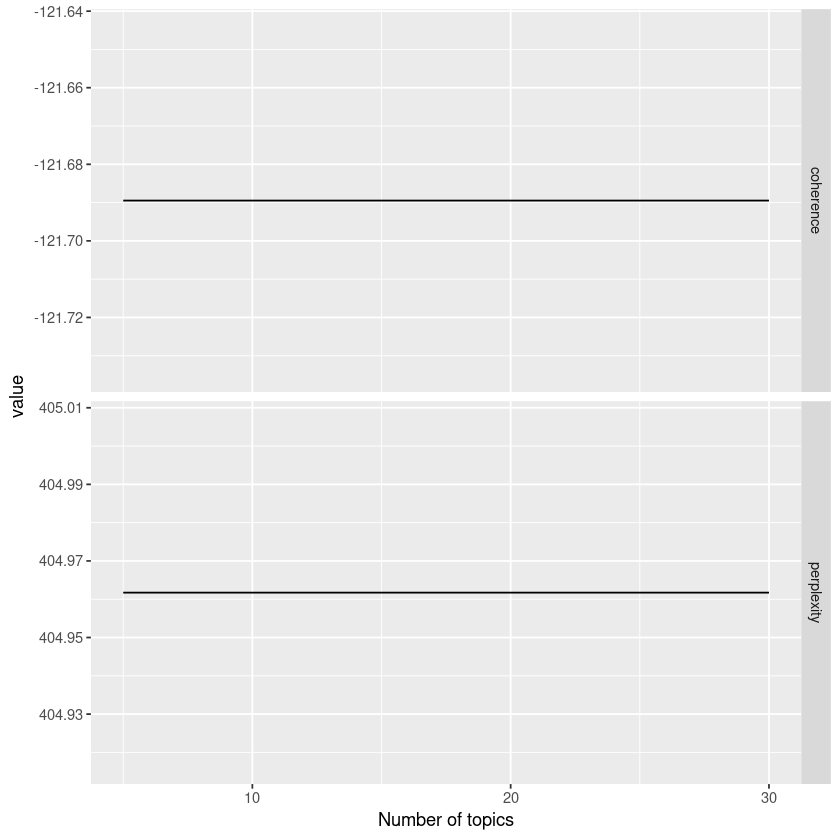

In [7]:
results = list()
for (k in c(5, 10, 15, 20, 25, 30)) {
    alpha = 1/((1:k)+sqrt(k))
    dtm = convert(dfm, to="topicmodels")
    LDA(dtm,k=k,control=list(seed=99,alpha=alpha))
    results[[as.character(k)]] = data.frame(
      perplexity=perplexity(lda),
      coherence=mean(topic_coherence(lda,dtm)))
}
bind_rows(results, .id="k") %>% 
  mutate(k=as.numeric(k)) %>%
  pivot_longer(-k) %>% 
  ggplot() + 
  geom_line(aes(x=k, y=value)) + 
  xlab("Number of topics") + 
  facet_grid(name ~ ., scales="free")